# 04. 분류

### [7] LightGBM
- Xgboost : 매우 뛰어난 부스팅 알고리즘이지만 학습 시간이 오래 걸림

- LightGBM
 - XGBoost 보다 학습에 걸리는 시간이 훨씬 적음
 - 메모리 사용량도 상대적으로 적음
 - XGBoost 의 예측 성능과 비슷
 - 단점 : 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움
 - 리프 중심 트리 분할 (Leaf Wise) 방식을 사용

- 균형 트리 분할 (Level Wise) :
 - 최대한 균형 잡힌 트리를 유지하면서 분할 -> 트리의 깊이가 최소화
 - 오버피팅에 더 강한 구조를 가질 수 있음
 - 단점 : 균형을 맞추기 위해 시간이 필요
- 리프 중심 트리 분할 (Leaf Wise) :
 - 최대 손실 값을 가지는 리프 노드를 지속적으로 분할 -> 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성
 - 예측 오류 손실을 최소화함

 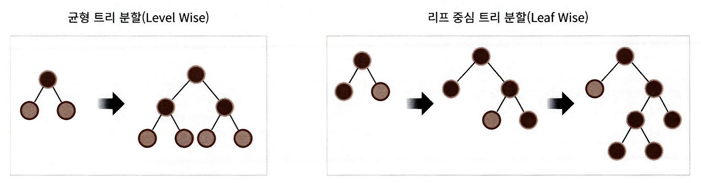

- LightGBM 의 파이썬 패키지명 : 'lightgbm'

사이킷런 래퍼 클래스만 설명

### [LightGBM 설치]

In [1]:
# 3.3.2 버전의 LightGBM 설치
!pip install lightgbm==3.3.2

In [2]:
# 설치가 수행됐는지 검증
import lightgbm
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### [LightGBM 하이퍼 파라미터]
- 리프 노드가 계속 분할되면서 트리의 깊이가 깊어짐 -> 트리 특성에 맞는 하이퍼 파라미터 설정이 필요함 (ex. max_depth를 매우 크게 가짐)


주요 파라미터
- num_iterations[default = 100] : 반복 수행하려는 트리의 개수를 지정
- learning_rate [default = 0.1] : 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
- max_depth [default = -1] : 트리 기반 알고리즘의 max_depth와 같음
- min_data_in_leaf [default = 20] : 결정 트리의 min_samples_leaf와 같은 파라미터
- num_leaves [deafult = 31] : 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting [deafult = gbdt] : 부스팅의 트리를 생성하는 알고리즘을 기술
- bagging_fraction [deafult =1.0] : 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율
- feature_fraction [deafult = 1.0] : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율
- lambda_l2 [deafult = 0.0] : L2 regulation 제어를 위한 값
- lambda_l1 [deafult = 0.0] : L1 regulation 제어를 위한 값

Learning Task 파라미터
- objective : 최솟값을 가져야 할 손실함수를 정의

### [하이처 파라미터 튜닝 방안]
기본 튜닝 방안 : num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것
- num_leaves : 개별 트리가 가질 수 있는 최대 리프의 개수
- min_data_in_leaf : 과적합을 개선하기 위한 중요한 파라미터 (사이킷런 래퍼 클래스에서 : min_child_samples)
- max_depth : 명시적으로 깊이의 크기를 제한

learning_rate를 작게 하면서 n_estimators를 크게 하는 것 : 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안
- 과적합 제어 : regularization(reg_lambda, reg_alpha)을 적용
- 학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 : colsample_bytree, subsample 파라미터 적용

### [파이썬 래퍼 LightGBM과 사이킷런 래퍼 XgBoost, LightGBM 하이퍼 파라미터 비교]
- (파이썬 래퍼) LightGBM
 - 사이킷런과 호환하기 위해 분류를 위한 LGBMClassifier와 회귀를 위한 LGBM Regressor 클래스를 래퍼 클래스로 생성

- (사이킷런 래퍼) XGBoost
 - 사이킷런 하이퍼 파라미터 명명 규칙에 따라 자신의 하이퍼 파라미터를 변경
- (사이킷런 래퍼) LightGBM
 - 하이퍼 파라미터를 사이킷런 XGBoost에 맞춰 변경

 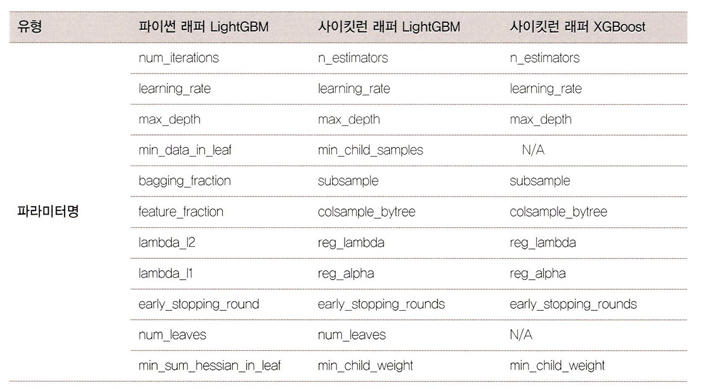

### [LightGBM 적용 - 위스콘신 유방암 예측]
XGBoost에서 사용한 위스콘신 유방암 데이터 세트를 이용해 LightGBM으로 예측

In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

=> 조기중단으로 111번 반복까지만 수행하고 학습을 종료

In [4]:
# 3장 평가에서 생성한 get_clf_eval() 함수 적용
# XGBoost 모델의 예측 성능을 평가

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score (y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0: .4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\ F1: {3:.4f}, AUC:{4:.4f}'. format(accuracy, precision, recall, f1, roc_auc))

In [5]:
# 학습된 LightGBM 모델을 기반으로 예측 성능 평가하기
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도:  0.9561, 정밀도: 0.9615, 재현율: 0.9740,\ F1: 0.9677, AUC:0.9877


LightGBM 파이썬 패키지인 lightgbm : 피처 중요도를 시각화할 수 있는 내장 API를 제공 (XGBoost 파이썬 패키지인 xgboost와 동일)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

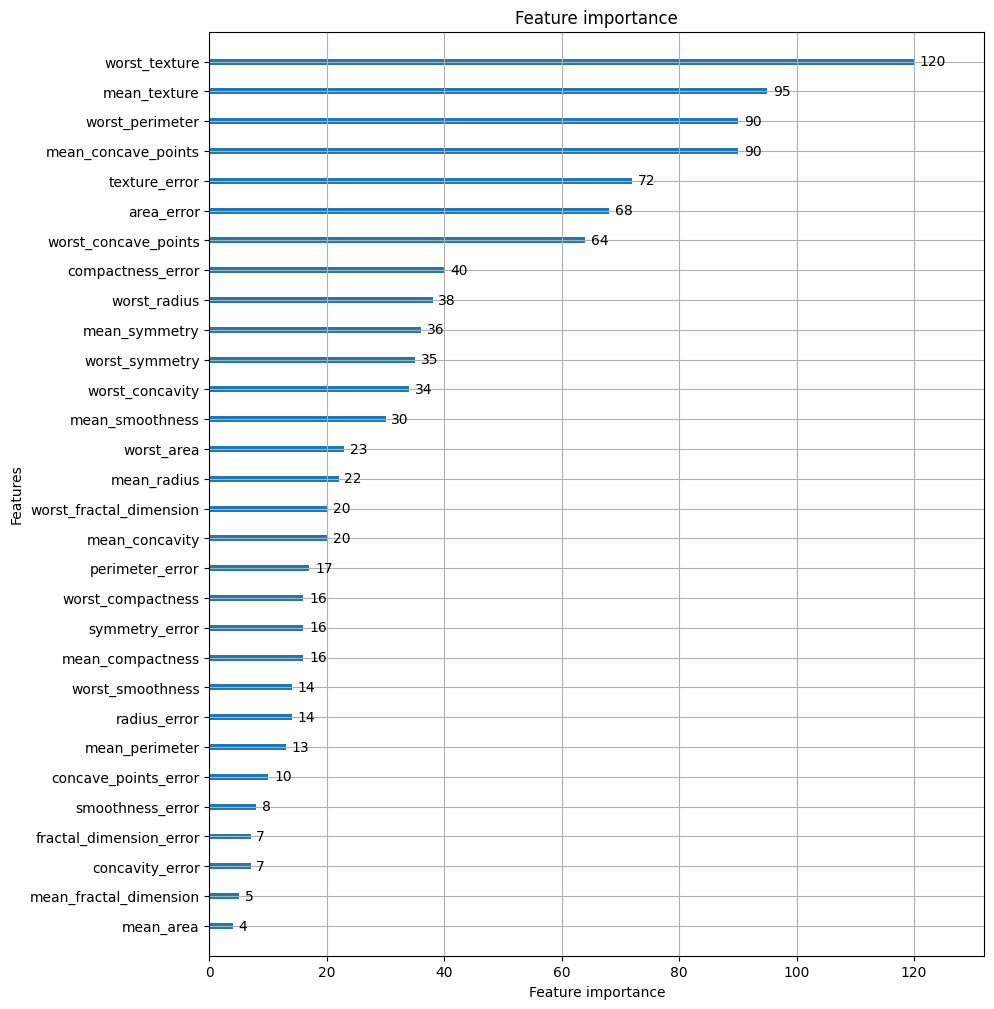

In [6]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

### [8] 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝
- Grid Search 방식
 - 하이퍼 파라미터 튜닝을 위해 사이킷런에서 제공하는 방식
 - 단점 : 튜닝해야 할 하이퍼 파라미터 개수가 많을 경우, 개별 하이퍼 파라미터의 값의 범위가 넓거나 학습 데이터가 대용량일 경우 -> 최적화 시간이 오래걸림
- 예시 : 아래와 같이 LightGBM의 6가지 하이퍼 파라미터를 최적화하려는 시도
 - 총 6000회에 걸쳐서 반복적으로 학습과 평가를 수행해야만 함 => 매우 오랜 수행 시간
 ```
params = {
    'max_depth' = [10,20,30,40,50],
    'num_leaves' = [35,45,55,65],
    'colsample_bytree' = [0.5,0.6,0.7,0.8,0.9],
    'subsample' = [0.5,0.6,0.7,0.8,0.9],
    'mid_child_weight' = [10,20,30,40],
    reg_alph = [0.01,0.05,0.1]
}
```

=> 실무의 대용량 학습 데이터에서 다른 방식을 적용함 : **'베이지안 최적화 기법'**

### [베이지안 최적화 개요]
베이지안 최적화
- 정의
 - 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서
 - 최대와 최소 함수 반환 값을 만드는 최적 입력값을 찾음
 - 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 베이지안 확률에 기반을 두는 최적화 기법
 - 새로운 데이터를 입력 받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만듦
- 중요 요소
 - 대체 모델(Surrogate Model) : 획득 함수로부터 최적 함수를 예측할 수 있는 입력값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선해 나감
 - 획득 함수(Acquisition Function) : 개선된 대체 모델을 기반으로 최적 입력값을 계산

베이지안 최적화
- [STEP 1]

 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과를 관측
 - 검은 색 원 : 특정 하이퍼 파라미터가 입력되었을 때 관측된 성능 지표 결괏값
 - 주황색 사선 : 찾아야 할 목표 최적함수

 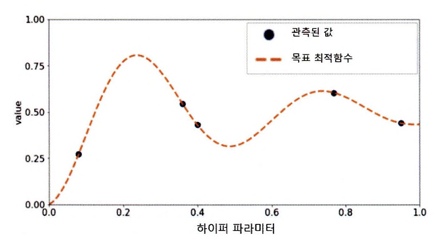

- [STEP 2]

 관측된 값을 기반으로 대체 모델은 최적 함수를 추천
 - 파란색 실선 : 대체 모델이 추정한 최적 함수
 - 옅은 파란색 영영 : 예측된 함수의 신뢰 구간 (추정된 함수의 결괏값 오류 편차, 추정 함수의 불확실성)

 최적 관측값 : y축 values에서 가장 높은 값을 가질 때의 하이퍼 파라미터

  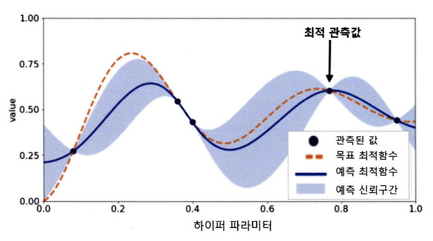

- [STEP 3]

 추정된 최적 함수를 기반으로 획득함수는 다음으로 관측할 하이퍼 파라미터 값을 계산

 획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달

 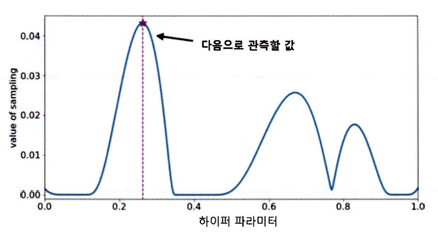



- [STEP 4]

 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적 함수를 예측 추정함

 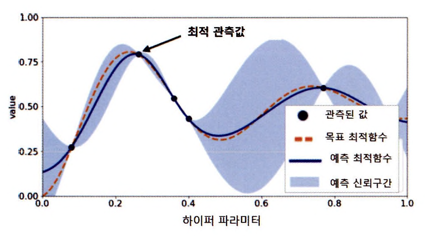

 - [STEP 3], [STEP 4]를 특정 회수만큼 반복

  대체 모델의 불확실성이 개선되고 점차 정확한 최적 함수 추정이 가능해짐

대체 모델은 최적 함수를 추정할 때 다양한 알고리즘을 사용 : 가우시안 프로세스

### [HyperOpt 사용하기]
- 가우시안 프로세스가 아닌 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator) 사용
- 베이지안 최적화를 머신러닝 모델의 하이퍼 파라미터 튜닝에 적용할 수 있게 제공되는 파이썬 패키지 : HyperOpt, Bayesian Optimization, Optuna

HyperOpt 사용법 소개

In [7]:
# HyperOpt 설치
!pip install hyperopt

- HyperOpt 주요 로직
 - 첫째 : 입력 변수명과 입력값의 검색 공간(Search Space) 설정
 - 둘째 : 목적 함수(Objective Function)의 설정
 - 마지막 : 목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추
- HyperOpt는 목적 함수 반환 값의 '최솟값'을 가지는 최적 입력값을 유추함

In [8]:
from hyperopt import hp

# -10 ~ 10까지 1 간격을 가지는 입력 변수 x와 -15 ~ 15까지 1 간격으로 입력 변수 y 설정
search_space = {'x' : hp.quniform('x', -10,10,1), 'y' : hp.quniform('y', -15,15,1)}

입력 값의 검색 공간을 제공하는 함수들
- 함수 인자
 - label : 입력 변수명
 - low : 최솟값
 - high : 최댓값
 - q : 간격
- hp.quniform(label,low,high,q) : label로 지정된 입력값 변수 검색 공간을 최솟값에서 최댓값까지 q의 간격을 가지고 설정
- hp.uniform(label,low,high) : 최솟값에서 최댓값까지 정규 분포 형태의 검색 공간 설정
- hp.randint(label,upper) : 0부터 최댓값까지 random한 정숫값으로 검색 공간 설정
- hp.loguniform(label,low,high) : exp(uniform(low,high)) 값을 반환, 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
- hp.choich(label, options) : 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정

목적 함수 생성

In [9]:
from hyperopt import STATUS_OK

# 목적 함수를 생성
# 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(searh_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

- fmin() 함수
 - 목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아줌
 - fn : 위에서 생성한 objective_func 와 같은 목적 함수
 - space : 위에서 생성한 search_space와 같은 검색 공간 딕셔너리
 - algo : 베이지안 최적화 적용 알고리즘
 - max_evals : 최적 입력값을 찾기 위한 입력값 시도 횟수
 - trals : 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는 데 사용
 - rstate : fmin()을 수행할 때마다 동일한 결괏값을 가질 수 있도록 설정하는 랜덤 시드

max_evals 값을 5로 설정  : 5번의 입력값 시도로 찾아내기

In [ ]:
from hyperopt import fmin, tpe, Trials

# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn=objective_func, space = search_space, algo=tpe.suggest, max_evals = 5, trials = trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

=> best_01 변숫값 : x가 -4.0, y가 12.0

=> 5번의 수행으로 어느 정도 최적값에 다가설 수 있음

max_evals 값을 20으로 설정  : 20번의 입력값 시도로 찾아내기

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space = search_space, algo=tpe.suggest, max_evals = 20, trials = trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

=> best_02 변숫값 : x는 2로, y는 15

베이지안 최적화를 이용해 20회 반복만으로 일정 수준의 최적값을 근사해 낼 수 있음

-fmin() 함수 인자 Trials 객체
 - 함수의 반복 수행 시마다 입력되는 변숫값들과 함수 반환값을 속성으로 가짐
 - results : 함수의 반복 수행 시마다 반환되는 반환값을 가짐
  - 파이썬 리스트 형태 : {'loss' : 함수 반환값, 'status' : 반환 상태값}
 - vals : 함수의 반복 수행 시마다 입력되는 입력 변숫값을 가짐
  - 딕셔너리 형태 : {'입력변수명': 개별 수행 시마다 입련된 값의 리스트}

In [ ]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값}와 같은 딕셔너리임
print(trial_val.results)

In [ ]:
# Trials 객체의 vals 속성에 {'입력변수명': 개별 수행 시마다 입련된 값의 리스트} 형태로 저장됨
print(trial_val.vals)

results와 vals 속성값들을 DataFrame으로 만들어서 좀 더 직관적으로 값을 확인하기

In [ ]:
import pandas as pd

# results에서 loss 키 값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

### [HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화]
HyperOpt를 이용하여 ML 모델의 하이퍼파라미터를 어떻게 최적화하는지 알아보기
- 적용해야 할 하이퍼 파라미터와 검색 공간을 설정, 목적 함수에서 XGBoost를 학습 후에 예측 성능 결과를 반환 값으로 설정
- fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용하여 최적의 예측 성능 결과를 반환하는 최적 입력값들을 결정

위스콘신 유방암 데이터 세트

In [19]:
# 전체 데이터 중 80% 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state=156)

# 앞서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=156)

- 하이퍼 파라미터 검색 공간 설정

In [20]:
from hyperopt import hp

# max_depth 는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1,2,1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
                    }

- 목적 함수 설정

두 가지 유의 사항
- 1. 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값 -> XGBoostClassifier의 정수형 하이퍼 파라미터 값을 설정할 때 정수형으로 형변환
- 2. HyperOpth의 목적 함수는 최솟값을 반환할 수 있도록 최적화 -> 정확도와 같이 값이 클수록 좋은 성능 지표일 경우 -1 곱한 뒤 반환, 더 큰 성능 지표가 더 작은 반환값이 되도록 만들어주기

objective_func() 만들기

In [23]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높은 수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐, 이를 평균해서 반환하되 -1을 곱함.
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}

In [24]:
# 최적 하이퍼 파라미터 도출
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:33<00:00,  1.48trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


In [25]:
# 정수형 하이퍼 파라미터 : 정수형으로 형 변환
# 실수형 하이퍼 파라미터 : 실수형으로 형 변환
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_chidl_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5), int(best['max_depth']),
    int(best['min_child_weight'])))


colsample_bytree:0.50265, learning_rate:0.19828, max_depth:15, min_chidl_weight:1


In [26]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5),
                            eval_metric='logloss',
                            early_stopping_rounds=50,
                            verbose=True
                            )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.51230	validation_1-logloss:0.55948
[1]	validation_0-logloss:0.40697	validation_1-logloss:0.47575
[2]	validation_0-logloss:0.32809	validation_1-logloss:0.41760
[3]	validation_0-logloss:0.27049	validation_1-logloss:0.37988
[4]	validation_0-logloss:0.22671	validation_1-logloss:0.34438
[5]	validation_0-logloss:0.19305	validation_1-logloss:0.31788
[6]	validation_0-logloss:0.16589	validation_1-logloss:0.30717
[7]	validation_0-logloss:0.14300	validation_1-logloss:0.30056
[8]	validation_0-logloss:0.12355	validation_1-logloss:0.29707
[9]	validation_0-logloss:0.10737	validation_1-logloss:0.28298
[10]	validation_0-logloss:0.09355	validation_1-logloss:0.26801
[11]	validation_0-logloss:0.08250	validation_1-logloss:0.26738
[12]	validation_0-logloss:0.07357	validation_1-logloss:0.26220
[13]	validation_0-logloss:0.06572	validation_1-logloss:0.26240
[14]	validation_0-logloss:0.05892	validation_1-logloss:0.25570
[15]	validation_0-logloss:0.05247	validation_1-logloss:0.25186
[1

### [11] 스태킹 앙상블

스태킹(Stacking) : 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출(배깅 및 부스팅과 공통점)
- 차이점 : 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행

두 종류의 모델
- 1. 개별적인 기반 모델
- 2. 최종 메타 모델 : 개별 기반의 모델의 예측 데이터를 학습 데이터로 만들어서 학습
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합 -> 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만듦

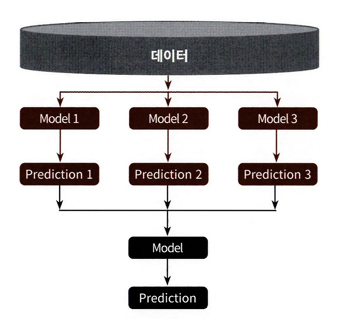

스태킹 앙상블 모델
- step1 : M x N 데이터 세트에 스태킹 앙상블 적용, ML 알고리즘 모델은 모두 3개
- step2 : 모델별로 각각 학습 시키기 -> 예측 수행 -> M개의 로우를 가진 1개의 레이블 값 도출
- step3 : 모델별로 도출된 예측 레이블 값을 합하기(스태킹) -> 새로운 데이터 세트 만들기 -> 최종 모델을 적용해 최종 예측하기

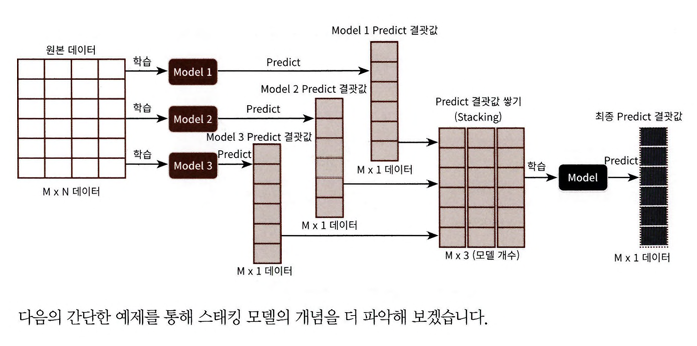

간단한 예제 살펴보기
### [기본 스태킹 모델]

In [27]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [28]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [29]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

In [30]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정홛고 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [31]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [32]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


### [CV 세트 기반의 스태킹]

- CV 세트 기반의 스태킹 모델 : 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용

- step1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성
- step2 :
 - 스텝1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성
 - 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합침 -> 메타 모델이 예측할 최종 테스트 데이터 세트를 생성
  - 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습 -> 최종적으로 생성된 테스트 데이터 세트를 예측 -> 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

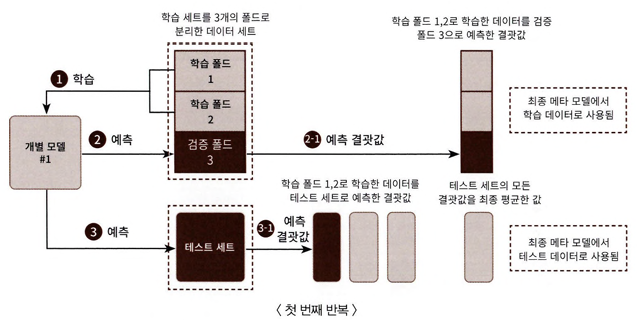

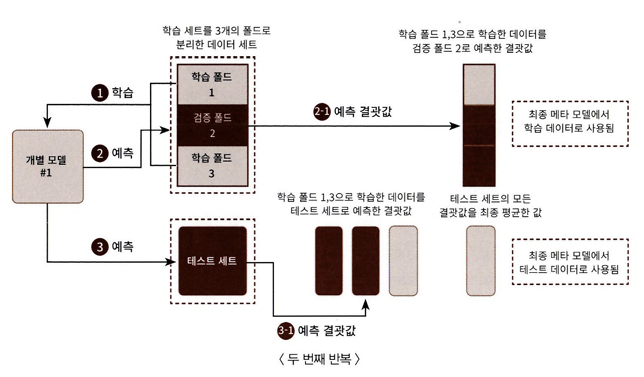

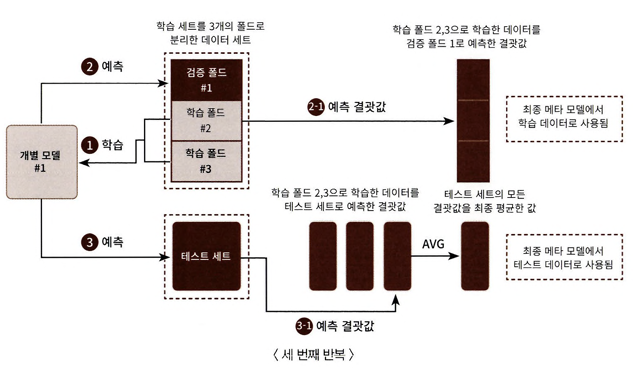

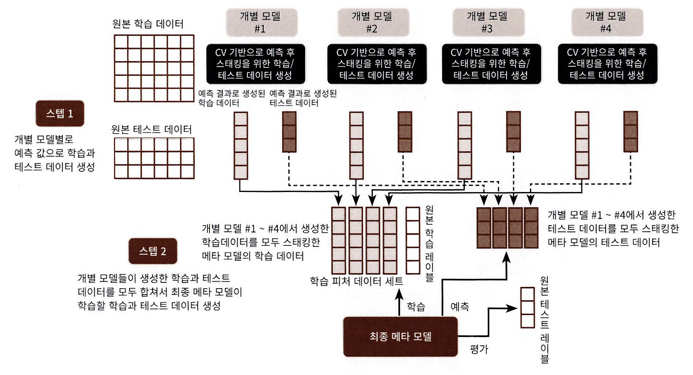

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds값으로 KFold 생성.
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf. split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [34]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  1 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  2 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  3 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  4 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  5 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  6 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [35]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [36]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9825
